# Neural Machine Translation by Jointly Learning to Align and Translate

_This notebook demonstrates the implementation of Seq2Seq architecture with attention mechanism proposed by [Bahdanau et al., 2014](https://arxiv.org/pdf/1409.0473.pdf) for neural machine translation (NMT)._


> _Sequence-to-sequence models are deep learning models that have achieved a lot of success in tasks like machine translation, text summarization, and image captioning. Google Translate started [using](https://blog.google/products/translate/found-translation-more-accurate-fluent-sentences-google-translate/) such a model in production in late 2016. These models are explained in the two pioneering papers ([Sutskever et al., 2014](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf), [Cho et al., 2014](http://emnlp2014.org/papers/pdf/EMNLP2014179.pdf)). (Excerpt from a [blog post](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/) by Jay Alammar)_

Sequence-to-sequence (aka seq2seq) model is an end-to-end deep learning model which transforms one sequence to another. It consists of two recurrent neural networks:
- encoder, which encodes an input sequence of variable size into a context vector of fixed size
- decoder, which unfolds the context vector into a new sequence (output).


![seq2seq model](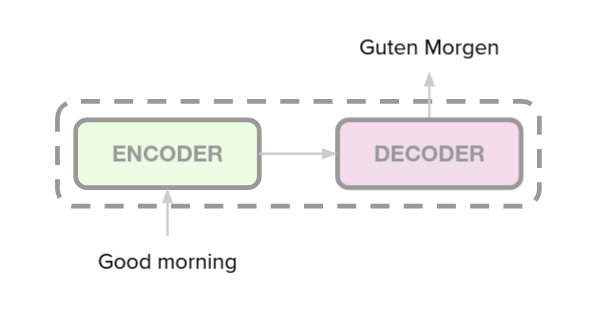 "Seq2Seq Model")


Seq2Seq NMT model can be thought of autoregressive language model where the decoder finds the target sequence that is the most probable conditioned on the input sequence. Mathematically, it can be formulated as follows:

$$
P(y|x) = P(y_1|x) P(y_2|y_1,x) \dots P(y_T|y_1, \dots, y_{T-1}, x)
$$

where $x$ is the input sequence and $y$ is the output sequence.


We will build a seq2seq model with attention for English to German translation using PyTorch.


In [ ]:
%%capture
# download the spacy language models for english and german
!python -m spacy download en --quiet
!python -m spacy download de --quiet

In [ ]:
%%capture
!pip install torchtext --upgrade

In [ ]:
%%capture
# download fasttext embeddings for english and german
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.de.vec
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec

## Imports


In [ ]:
import random
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import spacy
import torchtext
import torchtext.vocab as vocab
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator
from torchtext.data.metrics import bleu_score

import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

In [ ]:
# plot style configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

rcParams['figure.figsize'] = 12, 8

In [ ]:
# for reproducibility
# refer https://pytorch.org/docs/stable/notes/randomness.html
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Preprocessing and Loading


In [ ]:
spacy_en = spacy.load('en')
spacy_de = spacy.load('de')

def tokenize_en(text):
    """ Translates english text sequence into a list of tokens.
    """
    return [token.text for token in spacy_en.tokenizer(text)]

def tokenize_de(text):
    """ Translates german text sequence into a list of tokens.
    """
    return [token.text for token in spacy_de.tokenizer(text)]

PAD_TOKEN = '<pad>'
SOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'
UNK_TOKEN = '<unk>'

# english text field
en_text = Field(
    tokenize=tokenize_en, lower=True, include_lengths=True,
    pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN, unk_token=UNK_TOKEN,
)

# german text field
de_text = Field(
    tokenize=tokenize_de, lower=True, include_lengths=True,
    pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN, unk_token=UNK_TOKEN,
)

In [ ]:
data_fields = (('src', en_text), ('trg', de_text))

train_data, valid_data, test_data = Multi30k.splits(
    exts=('.en', '.de'), fields=data_fields
)

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 1.61MB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 277kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 265kB/s]


In [ ]:
# load the pretrained fasttext embeddings and build the english vocabulary
en_fast_embed = vocab.Vectors(name='wiki.en.vec', cache='.', unk_init = torch.Tensor.normal_)
en_text.build_vocab(train_data.src, max_size=10000, min_freq=2, vectors=en_fast_embed)

del en_fast_embed

In [ ]:
# load the pretrained fasttext embeddings build the german vocabulary
de_fast_embed = vocab.Vectors(name='wiki.de.vec', cache='.', unk_init = torch.Tensor.normal_)
de_text.build_vocab(train_data.trg, max_size=10000, min_freq=2, vectors=de_fast_embed)

del de_fast_embed

In [ ]:
PAD_IDX = de_text.vocab.stoi[PAD_TOKEN]
SOS_IDX = de_text.vocab.stoi[SOS_TOKEN]
EOS_IDX = de_text.vocab.stoi[EOS_TOKEN]
UNK_IDX = de_text.vocab.stoi[UNK_TOKEN]

print(f'English vocabulary: {len(en_text.vocab)} words')
print(f'German vocabulary: {len(de_text.vocab)} words')

English vocabulary: 5893 words
German vocabulary: 7855 words


In [ ]:
print(f'# of training examples: {len(train_data.examples)}')
print(f'# of validation examples: {len(valid_data.examples)}')
print(f'# of testing examples: {len(test_data.examples)}')

print(train_data[0].__dict__.keys())
print(train_data[0].__dict__.values())

# of training examples: 29000
# of validation examples: 1014
# of testing examples: 1000
dict_keys(['src', 'trg'])
dict_values([['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.'], ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']])


In [ ]:
BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    device=device
)

In [ ]:
# sanity check to see if data loader is working
x = next(iter(train_iterator))

print({'source': x.src[0].shape, 'source_lengths': x.src[1].shape})
print({'target': x.trg[0].shape, 'target_lengths': x.trg[1].shape})

{'source': torch.Size([16, 32]), 'source_lengths': torch.Size([32])}
{'target': torch.Size([21, 32]), 'target_lengths': torch.Size([32])}


## Model Architecture

![seq2seq model with attention](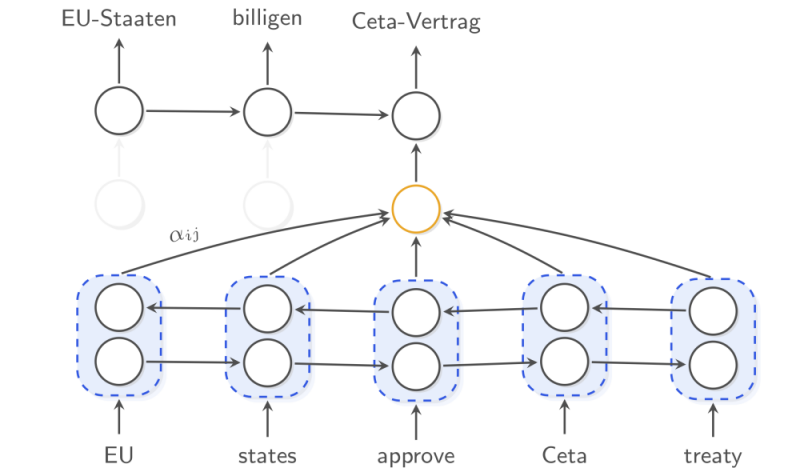 "Seq2Seq Model with Bahdanua Attention")

(source: https://bastings.github.io/annotated_encoder_decoder/)


### Encoder Module

Encoder reads the input sequence and generate a fixed size context vector. However, because it's very hard for the encoder to encode the entire input sequence into a single vector, the encoder also produces the sequence of hidden states for each token of input sequence. Encoder can be either stacked LSTMs or stacked GRUs where each layer's output are passed as input sequence to the next layer. The final layer's hidden states act as a context vector.

For the implementation in this notebook, we will be using a bidirectional GRU (forward + backward) as a encoder. A forward GRU reads the input sequence from left to right whereas a backward GRU reads the input sequence from right to left. The advantage of using a bidirectional GRU over unidirectional GRU is that we will be able to preserve information from both past and future. Mathematically, it can expressed as follows:

$$
\begin{align}
h_t^\rightarrow &= \text{GRU}^\rightarrow(e(x_t^\rightarrow),\ h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{GRU}^\leftarrow(e(x_t^\leftarrow),\ h_{t-1}^\leftarrow)
\end{align}
$$

where 
- $x_t$ denotes the input token (word) at time step $t$
- $e(x_t^\rightarrow)$ denotes the embedded input token at time step $t$
- $h_t^\rightarrow$ and $h_t^\leftarrow$ denotes the forward and backward hidden state at time step $t$ respectively

We will concatenate the final forward and backward hidden state to preserve the information context from both past and future and apply linear layer followed by relu non-linearity to obtain the context vector $z$ as follows:

$$
z = f([h_t^\rightarrow,\ h_t^\leftarrow])
$$

where
- $[h_t^\rightarrow,\ h_t^\leftarrow]$ denotes concatenation of the final forward and backward hidden state
- $f$ denotes linear layer followed by relu non-linearity

Encoder GRU returns the following:
- `outputs`: stacked forward and backward hidden states from the last layer
- `hidden`: context vector $z$ which acts as initial hidden state for the decoder.


In [ ]:
class Encoder(nn.Module):
    """ Encoder encodes the input sequence into a dense embedded context.
    """
    
    def __init__(self, input_size, embed_size, hidden_size, n_layers=1, dropout_rate=0.5):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate
        
        self.embedding = nn.Embedding(input_size, embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, n_layers, bidirectional=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
    

    def load_pretrained_embeddings(self, embeddings, fine_tune=False):
        self.embedding.weight = nn.Parameter(embeddings)
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune
    
    
    def forward(self, x, lengths):
        """ x: (seq_len, batch_size)
            lengths: (batch_size)
        """
        embed = self.dropout(self.embedding(x))  # (seq_len, batch_size, embed_size)
        
        # packing the embedding sequence to avoid unnecessary computations
        # refer https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch
        packed_embed = pack_padded_sequence(embed, lengths.to('cpu'))
        packed_outputs, hidden = self.rnn(packed_embed)
        outputs, _ = pad_packed_sequence(packed_outputs)
        
        # outputs is a non-packed sequence of all hidden states from last layer
        # outputs: (seq_len, batch_size, hidden_size * 2)
        # hidden is the final non-padded time stepped state
        # hidden: (n_layers * 2, batch_size, hidden_size)
        
        # initial decoder hidden state
        hidden = F.relu(self.fc(torch.cat([h for h in hidden[-2:]], dim=1)))  # (batch_size, hidden_size)
        
        # outputs: (seq_len, batch_size, hidden_size * 2)
        # hidden: (batch_size, hidden_size)
        return outputs, hidden

### Attention Module

Although RNNs are good for capturing temporal dependencies, but they fail to preserve the complete context for long sequences. It is very likely that the information context for the intial time steps would be lost by the end of the sequence since we are encoding the input sequence into a single context vector. 

Wouldn't it be nice if we are able to focus only on the relevant parts of the input sequence? This is where "Attention Mechanism" comes to provide the luxury of focusing on different parts of encoded sequence thereby allowing the context to be preserved from beginning to end during the decoding stage. This technique was introduced by [Bahdanau et al., 2014](https://arxiv.org/abs/1409.0473) and [Luong et al., 2015](https://arxiv.org/abs/1508.04025).

For the implementation in this notebook, we will be using attention mechanism introduced by [Bahdanau et al., 2014](https://arxiv.org/abs/1409.0473) which is a MLP based additive attention. We calculate the alignment scores using the encoder outputs and decoder hidden states as follows:

$$
e_t = \text{relu}(W_1 H + W_2 s_{t-1}) \\
\alpha_t = \text{softmax}(V \cdot e_t)
$$

where
- e_t is the attention energy at the time step $t$
- $W_1$ and $W_2$ are learned attention parameters for encoder outputs $H$ and previous decoder hidden state $s_{t-1}$ respectively
- $V$ is another learned attention parameter for the attention energy $e_t$
- $\alpha_t$ is the alignment score for time step $t$

We use the above alignment scores to calculate the weighted sum of encoder outputs also known as context vector $c_t$ for time step $t$ as follows:

$$
c_t = \alpha_t H
$$

Attention Module returns the following:
- `context_vector`: weighted sum of encoder outputs wrt alignment score
- `alphas`: alignment scores indicating how well inputs around position $i$ match with outputs around position $j$


In [ ]:
class BahdanauAttention(nn.Module):
    """ Implements Additive attention proposed by Bahdanau et al., 2014.
        refer https://arxiv.org/abs/1409.0473
    """
    
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.hidden_size = hidden_size
        
        self.W1 = nn.Linear(hidden_size * 2, hidden_size, bias=False)
        self.W2 = nn.Linear(hidden_size, hidden_size, bias=False)
        self.V = nn.Linear(hidden_size, 1, bias=False)
    
    
    def forward(self, hidden, enc_outputs, enc_masks):
        """ hidden: (batch_size, hidden_size)
            enc_outputs: (seq_len, batch_size, hidden_size * 2)
            enc_masks: (batch_size, seq_len)
        """
        seq_len = enc_outputs.shape[0]
        
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)  # (batch_size, seq_len, hidden_size)
        enc_outputs = enc_outputs.permute(1, 0, 2)  # (batch_size, seq_len, hidden_size * 2)
        
        # calculate alignment scores
        energy = F.relu(self.W1(enc_outputs) + self.W2(hidden))  # (batch_size, seq_len, hidden_size)
        scores = self.V(energy)  # (batch_size, seq_len, 1)
        scores = scores.squeeze(2)  # (batch_size, seq_len)
        
        # mask out invalid positions
        scores = scores.masked_fill(enc_masks == 0, float('-inf'))  # (batch_size, seq_len)
        
        # calculate the attention weights (prob) from alignment scores
        alphas = F.softmax(scores, dim=-1)  # (batch_size, seq_len)
        
        # calculate context vector
        context_vector = torch.bmm(alphas.unsqueeze(1), enc_outputs)  # (batch_size, 1, hidden_size * 2)
        
        # context_vector: (batch_size, 1, hidden_size * 2)
        # alphas: (batch_size, seq_len)
        return context_vector, alphas

### Decoder Module With Attention

Decoder is a conditional GRU since we will be using it as a language model to decode the output sequence conditioned on generated sequence so far and input sequence. Here the decoder contains the attention module which allows to preserve the information context and generate output sequence of better quality.

For the implementation in this notebook, we will be using a unidirectional GRU with attention module. The decoder generates next output word with high probability at time step using the current output word, weighted encoder outputs, previous decoder hidden state as follows:

$$
s_t = \text{GRU}(e(y_t), c_t, s_{t-1}) \\
\hat{y}_{t+1} = f([e(y_t),\ c_t,\ s_t])
$$

where
- $y_t$ denotes the current output token (word) at time step $t$
- $e(y_t)$ denotes the current embedded output token at time step $t$
- $c_t$ denotes the context vector (weighted encoder outputs) at time step $t$
- $s_{t-1}$ and $s_t$ denotes the previous and current decoder hidden state
- $f$ denotes a linear layer
- $\hat{y}_{t+1}$ denotes next predicted word in the output sequence


In [ ]:
class DecoderWithAttention(nn.Module):
    """ Decoder decodes the encoded dense embedding context into a sequence 
        with use of attention mechanism.
    """
    def __init__(self, output_size, embed_size, hidden_size, n_layers=1, dropout_rate=0.5):
        super(DecoderWithAttention, self).__init__()
        self.output_size = output_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate
        
        self.embedding = nn.Embedding(output_size, embed_size)
        self.rnn = nn.GRU(embed_size + hidden_size * 2, hidden_size, n_layers, bidirectional=False, dropout=dropout_rate)
        self.attention = BahdanauAttention(hidden_size)
        self.fc = nn.Linear(embed_size + hidden_size + hidden_size * 2, output_size)
        self.dropout = nn.Dropout(dropout_rate)
        
    
    def load_pretrained_embeddings(self, embeddings, fine_tune=False):
        self.embedding.weight = nn.Parameter(embeddings)
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune
    
    
    def forward(self, x, hidden, enc_outputs, enc_masks):
        """ x: (batch_size)
            hidden: (batch_size, hidden_size)
            enc_outputs: (seq_len, batch_size, hidden_size * 2)
            enc_masks: (batch_size, seq_len)
        """
        embed = self.dropout(self.embedding(x.unsqueeze(0)))  # (1, batch_size, embed_size)
        
        # calculate attention weights and context vector
        context_vector, alphas = self.attention(hidden, enc_outputs, enc_masks)
        
        # context_vector: (batch_size, 1, hidden_size * 2)
        # alphas: (batch_size, seq_len)
        
        context_vector = context_vector.permute(1, 0, 2)  # (1, batch_size, hidden_size * 2)
        
        # input to the rnn is a concatenation of embedding and weighted encoder states (context)
        rnn_input = torch.cat((embed, context_vector), dim=2)  # (1, batch_size, embed_size + hidden_size * 2)
        
        # update the rnn hidden state
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        # output: (seq_len=1, batch_size, hidden_size)
        # hidden: (n_layers=1, batch_size, hidden_size)
        # seq_len and n_layers are always equal to 1 for this decoder
        
        assert (output == hidden).all()
        
        embed = embed.squeeze(0)  # (batch_size, embed_size)
        output = output.squeeze(0)  # (batch_size, hidden_size)
        context_vector = context_vector.squeeze(0)  # (batch_size, hidden_size * 2)
        
        prediction = self.fc(torch.cat((embed, output, context_vector), dim=1))  # (batch_size, output_size)
        
        hidden = hidden.squeeze(0)  # (batch_size, hidden_size)
        
        # prediction: (batch_size, output_size)
        # hidden: (batch_size, hidden_size)
        # alphas: (batch_size, seq_len)
        return prediction, hidden, alphas

### Seq2Seq Model With Attention


In [ ]:
class Seq2SeqWithAttention(nn.Module):
    """ Seq2Seq wrapper for encoder and decoder.
    """
    
    def __init__(self, encoder, decoder, pad_idx):
        super(Seq2SeqWithAttention, self).__init__()
        self.pad_idx = pad_idx
        
        self.encoder = encoder
        self.decoder = decoder
    
    
    def forward(self, source, source_lengths, target, teacher_force_ratio=0.5):
        """ source: (source_seq_len, batch_size)
            source_lengths: (batch_size)
            target: (target_seq_len, batch_size)
        """
        target_seq_len, batch_size = target.shape
        target_vocab_size = self.decoder.output_size
        
        # initialize tensor to store decoder outputs
        outputs = torch.zeros((target_seq_len, batch_size, target_vocab_size)).to(source.device)
        
        # outputs: (target_seq_len, batch_size, output_size)
        
        # encode the source sequence
        enc_outputs, hidden = self.encoder(source, source_lengths)
        
        # enc_outputs: (seq_len, batch_size, hidden_size * 2)
        # hidden: (batch_size, hidden_size)
        
        # create mask for source sequence
        enc_masks = (source != self.pad_idx).permute(1, 0)  # (batch_size, seq_len)
        
        # initial input to the decoder is the SOS_TOKEN
        x = target[0, :]  # (batch_size)
        
        for t in range(1, target_seq_len):
            # decode the encoded sequence for current time step
            output, hidden, _ = self.decoder(x, hidden, enc_outputs, enc_masks)
            
            # output: (batch_size, output_size)
            # hidden: (batch_size, hidden_size)
            
            # store the decoder outputs for current time step
            outputs[t] = output
            
            # get the highest predicted token (best word) for current time step
            top1 = output.argmax(dim=1)
            
            # teacher forcing ratio is the way to control how many times 
            # we feed the actual next word as input to the decoder
            # teacher forcing ratio of 0.5 indicates that 50% of the time
            # the decoder sees the actual next word
            x = target[t] if random.random() < teacher_force_ratio else top1
        
        # outputs: (target_seq_len, batch_size, output_size)
        return outputs

## Helper Utilities


In [ ]:
def model_summary(model):
    print(model)
    print(f'# of trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')
    print(f'# of non-trainable params: {sum(p.numel() for p in model.parameters() if not p.requires_grad)}')

In [ ]:
def convert_ids_to_text(ids, vocab, eos_idx, unk_idx):
    """ Converts token ids to text.
    """
    if ids.dim() == 1:
        output_tokens = []
        for token_id in ids:
            if token_id == eos_idx:
                break
            else:
                output_tokens.append(vocab.itos[token_id])
        return output_tokens
    
    elif ids.dim() == 2:
        return [convert_ids_to_text(ids[:, i], vocab, eos_idx, unk_idx) for i in range(ids.size(1))]
    
    raise RuntimeError(f'ids has {ids.size()} dimensions, expected 2 dimensions')

## Training


In [ ]:
def train_fn(model, iterator, optimizer, criterion, clip=1.0):
    model.train()
    total_loss = 0
    steps = 0
    
    tk0 = tqdm(iterator, total=len(iterator), position=0, leave=True)
    
    for idx, batch in enumerate(tk0):
        source, source_lengths = batch.src
        target, target_lengths = batch.trg

        # source: (source_seq_len, batch_size), source_lengths: (batch_size)
        # target: (target_seq_len, batch_size), target_lengths: (batch_size)

        # forward pass
        optimizer.zero_grad()
        output = model(source, source_lengths, target)  # (target_seq_len, batch_size, output_size)
        
        # ignoring SOS_TOKEN
        output = output[1:]  # ((target_seq_len - 1), batch_size, output_size)
        target = target[1:]  # ((target_seq_len - 1), batch_size)
        
        # calculate the loss
        loss = criterion(
            output[1:].view(-1, output.shape[-1]),  # ((target_seq_len - 1) * batch_size, output_size)
            target[1:].view(-1)  # ((target_seq_len - 1) * batch_size)
        )
        total_loss += loss.item()
        steps += 1

        output = output.argmax(dim=-1)  # ((target_seq_len - 1), batch_size)

        # backward pass
        loss.backward()

        # clip gradients to avoid exploding gradients issue
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        # update model parameters
        optimizer.step()
        
        tk0.set_postfix(loss=total_loss/steps)
        
    tk0.close()

    perplexity = np.exp(total_loss / len(iterator))
    
    return output, perplexity

In [ ]:
def eval_fn(model, iterator, criterion):
    model.eval()
    total_loss = 0.0
    steps = 0
    hypotheses = []
    references = []
    
    tk0 = tqdm(iterator, total=len(iterator), position=0, leave=True)
    
    with torch.no_grad():
        for idx, batch in enumerate(tk0):
            source, source_lengths = batch.src
            target, target_lengths = batch.trg
            
            # source: (source_seq_len, batch_size), source_lengths: (batch_size)
            # target: (target_seq_len, batch_size), target_lengths: (batch_size)
            
            # forward pass
            output = model(source, source_lengths, target)  # (target_seq_len, batch_size, output_size)
            
            # ignoring SOS_TOKEN
            output = output[1:]  # ((target_seq_len - 1), batch_size, output_size)
            target = target[1:]  # ((target_seq_len - 1), batch_size)
            
            # calculate the loss
            loss = criterion(
                output.view(-1, output.shape[-1]),  # ((target_seq_len - 1) * batch_size, output_size)
                target.view(-1)  # ((target_seq_len - 1) * batch_size)
            )
            total_loss += loss.item()
            steps += 1
            
            output = output.argmax(dim=-1)  # ((target_seq_len - 1), batch_size)

            # converting the ids to tokens (used later for calculating BLEU score)
            pred_tokens = convert_ids_to_text(output, de_text.vocab, EOS_IDX, UNK_IDX)
            target_tokens = convert_ids_to_text(target, de_text.vocab, EOS_IDX, UNK_IDX)

            hypotheses += pred_tokens
            references += [[token] for token in target_tokens]
            
            tk0.set_postfix(loss=total_loss/steps)
            
    tk0.close()
            
    perplexity = np.exp(total_loss / len(iterator))
    bleu4 = bleu_score(hypotheses, references)

    return output, perplexity, bleu4

In [ ]:
# hyperparameters
INPUT_SIZE = len(en_text.vocab)  # source vocab size
OUTPUT_SIZE = len(de_text.vocab)  # target vocab size
ENC_EMBED_SIZE = en_text.vocab.vectors.shape[1]
DEC_EMBED_SIZE = de_text.vocab.vectors.shape[1]
HIDDEN_SIZE = 512
N_LAYERS = 1
DROPOUT_RATE = 0.5
N_EPOCHS = 50
CLIP = 1.0

In [ ]:
encoder = Encoder(INPUT_SIZE, ENC_EMBED_SIZE, HIDDEN_SIZE, N_LAYERS, DROPOUT_RATE)
# load the pre-trained fasttext english embedding
encoder.load_pretrained_embeddings(en_text.vocab.vectors)

decoder = DecoderWithAttention(OUTPUT_SIZE, DEC_EMBED_SIZE, HIDDEN_SIZE, N_LAYERS, DROPOUT_RATE)
# load the pre-trained fasttext german embedding
encoder.load_pretrained_embeddings(de_text.vocab.vectors)

model = Seq2SeqWithAttention(encoder, decoder, PAD_IDX).to(device)
model_summary(model)

Seq2SeqWithAttention(
  (encoder): Encoder(
    (embedding): Embedding(5893, 300)
    (rnn): GRU(300, 512, dropout=0.5, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): DecoderWithAttention(
    (embedding): Embedding(7855, 300)
    (rnn): GRU(1324, 512, dropout=0.5)
    (attention): BahdanauAttention(
      (W1): Linear(in_features=1024, out_features=512, bias=False)
      (W2): Linear(in_features=512, out_features=512, bias=False)
      (V): Linear(in_features=512, out_features=1, bias=False)
    )
    (fc): Linear(in_features=1836, out_features=7855, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)
# of trainable params: 23421655
# of non-trainable params: 2356500


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=3, threshold=0.001, mode='max'
)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [ ]:
best_bleu4 = float('-inf')
es_patience = 5
patience = 0
model_path = 'model.pth'


for epoch in range(0, N_EPOCHS + 1):
    # one epoch training
    _, train_perplexity = train_fn(model, train_iterator, optimizer, criterion, CLIP)
    
    # one epoch validation
    _, valid_perplexity, valid_bleu4 = eval_fn(model, valid_iterator, criterion)
    
    print(f'Epoch: {epoch}, Train perplexity: {train_perplexity:.4f}, Valid perplexity: {valid_perplexity:.4f}, Valid BLEU4: {valid_bleu4:.4f}')
    
    scheduler.step(valid_bleu4)
    
    # early stopping
    is_best = valid_bleu4 > best_bleu4
    if is_best:
        print(f'BLEU score improved ({best_bleu4:.4f} -> {valid_bleu4:.4f}). Saving Model!')
        best_bleu4 = valid_bleu4
        patience = 0
        torch.save(model.state_dict(), model_path)
    else:
        patience += 1
        print(f'Early stopping counter: {patience} out of {es_patience}')
        if patience == es_patience:
            print(f'Early stopping! Best BLEU4: {best_bleu4:.4f}')
            break


Epoch: 0, Train perplexity: 122.7940, Valid perplexity: 71.3972, Valid BLEU4: 0.0698
BLEU score improved (-inf -> 0.0698). Saving Model!



Epoch: 1, Train perplexity: 42.9007, Valid perplexity: 43.0670, Valid BLEU4: 0.1189
BLEU score improved (0.0698 -> 0.1189). Saving Model!



Epoch: 2, Train perplexity: 26.0137, Valid perplexity: 30.9576, Valid BLEU4: 0.1437
BLEU score improved (0.1189 -> 0.1437). Saving Model!



Epoch: 3, Train perplexity: 18.5959, Valid perplexity: 27.4752, Valid BLEU4: 0.1688
BLEU score improved (0.1437 -> 0.1688). Saving Model!



Epoch: 4, Train perplexity: 14.1616, Valid perplexity: 23.4784, Valid BLEU4: 0.1810
BLEU score improved (0.1688 -> 0.1810). Saving Model!



Epoch: 5, Train perplexity: 11.4378, Valid perplexity: 23.8058, Valid BLEU4: 0.1910
BLEU score improved (0.1810 -> 0.1910). Saving Model!



Epoch: 6, Train perplexity: 9.4242, Valid perplexity: 22.5308, Valid BLEU4: 0.2036
BLEU score improved (0.1910 -> 0.2036). Saving Model!



Epoch: 7, Train perplexity: 8.2411, Valid perplexity: 21.9199, Valid BLEU4: 0.2016
Early stopping counter: 1 out of 5



Epoch: 8, Train perplexity: 7.2823, Valid perplexity: 21.5038, Valid BLEU4: 0.2070
BLEU score improved (0.2036 -> 0.2070). Saving Model!



Epoch: 9, Train perplexity: 6.5045, Valid perplexity: 21.6420, Valid BLEU4: 0.2058
Early stopping counter: 1 out of 5



Epoch: 10, Train perplexity: 5.9656, Valid perplexity: 22.0724, Valid BLEU4: 0.2188
BLEU score improved (0.2070 -> 0.2188). Saving Model!



Epoch: 11, Train perplexity: 5.4895, Valid perplexity: 20.6599, Valid BLEU4: 0.2151
Early stopping counter: 1 out of 5



Epoch: 12, Train perplexity: 5.0381, Valid perplexity: 23.1095, Valid BLEU4: 0.2140
Early stopping counter: 2 out of 5



Epoch: 13, Train perplexity: 4.7100, Valid perplexity: 21.4077, Valid BLEU4: 0.2089
Early stopping counter: 3 out of 5



Epoch: 14, Train perplexity: 4.3773, Valid perplexity: 22.7004, Valid BLEU4: 0.2113
Early stopping counter: 4 out of 5



Epoch: 15, Train perplexity: 3.7289, Valid perplexity: 21.8551, Valid BLEU4: 0.2230
BLEU score improved (0.2188 -> 0.2230). Saving Model!



Epoch: 16, Train perplexity: 3.5078, Valid perplexity: 22.2259, Valid BLEU4: 0.2231
BLEU score improved (0.2230 -> 0.2231). Saving Model!



Epoch: 17, Train perplexity: 3.4755, Valid perplexity: 22.0518, Valid BLEU4: 0.2213
Early stopping counter: 1 out of 5



Epoch: 18, Train perplexity: 3.3648, Valid perplexity: 20.5564, Valid BLEU4: 0.2245
BLEU score improved (0.2231 -> 0.2245). Saving Model!



Epoch: 19, Train perplexity: 3.3309, Valid perplexity: 23.0093, Valid BLEU4: 0.2257
BLEU score improved (0.2245 -> 0.2257). Saving Model!



Epoch: 20, Train perplexity: 3.3363, Valid perplexity: 22.1326, Valid BLEU4: 0.2273
BLEU score improved (0.2257 -> 0.2273). Saving Model!



Epoch: 21, Train perplexity: 3.3010, Valid perplexity: 21.3286, Valid BLEU4: 0.2196
Early stopping counter: 1 out of 5



Epoch: 22, Train perplexity: 3.2085, Valid perplexity: 21.9630, Valid BLEU4: 0.2221
Early stopping counter: 2 out of 5



Epoch: 23, Train perplexity: 3.1944, Valid perplexity: 21.0527, Valid BLEU4: 0.2258
Early stopping counter: 3 out of 5



Epoch: 24, Train perplexity: 3.1722, Valid perplexity: 23.5915, Valid BLEU4: 0.2245
Early stopping counter: 4 out of 5



Epoch: 25, Train perplexity: 3.1111, Valid perplexity: 22.7558, Valid BLEU4: 0.2231
Early stopping counter: 5 out of 5
Early stopping! Best BLEU4: 0.2273


In [ ]:
# evaluate the model on test data
model.load_state_dict(torch.load(model_path, map_location=device))

print('Evaluating the model on test data ...')
_, test_perplexity, test_bleu4 = eval_fn(model, test_iterator, criterion)
print(f'Test perplexity: {test_perplexity:.4f}, Test BlEU4: {test_bleu4:.4f}')

Evaluating the model on test data ...



Test perplexity: 21.3412, Test BlEU4: 0.2273


## Inference


In [ ]:
def greedy_decode(model, sentence, max_len=100):
    model.eval()
    
    if isinstance(sentence, str):
        tokens = [token.text.lower() for token in spacy_de(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    
    token_ids = [SOS_IDX] + [en_text.vocab.stoi.get(token, UNK_TOKEN) for token in tokens] + [EOS_IDX]
    
    source = torch.tensor(token_ids, dtype=torch.long).unsqueeze(1).to(device)  # (source_seq_len, 1)
    source_length = torch.tensor([len(source)], dtype=torch.long)  # (source_seq_len)
    
    # encode the source sequence
    with torch.no_grad():
        enc_outputs, hidden = model.encoder(source, source_length)
    
    # enc_outputs: (source_seq_len, 1, hidden_size * 2)
    # hidden: (1, hidden_size)
    
    # create mask for source sequence
    enc_masks = (source != PAD_IDX).permute(1, 0)  # (1, seq_len)
    
    target_ids = [SOS_IDX]
    attention_scores = torch.zeros(max_len, 1, len(token_ids)).to(device)  # (max_len, 1, source_seq_len)
    
    for t in range(max_len):
        target = torch.tensor([target_ids[-1]], dtype=torch.long).to(device)
        
        # decode the sequence
        with torch.no_grad():
            output, hidden, attention = model.decoder(target, hidden, enc_outputs, enc_masks)
            
            # output: (1, output_size)
            # hidden: (1, hidden_size)
            # attention: (1, source_seq_len)
            
        attention_scores[t] = attention
        
        target_id = output.argmax(dim=-1).item()
        target_ids.append(target_id)
        
        # stop decoding if we encounter EOS_TOKEN or reach the max length
        if target_id == EOS_IDX or len(target_ids) >= max_len:
            break
    
    target_tokens = [de_text.vocab.itos[id] for id in target_ids]
    attention_scores = attention_scores[:len(target_tokens)-1].squeeze(1).cpu().detach().numpy()

    # target_tokens: list of size (target_seq_len - 1)
    # attention_scores: (target_seq_len - 1, 1, source_seq_len)
    
    return target_tokens[1:], attention_scores

In [ ]:
def plot_attention_scores(source, target, attention):
    
    if isinstance(source, str):
        source = [token.lower for token in source.split(' ')] + [EOS_TOKEN]
    else:
        source = [token.lower() for token in source] + [EOS_TOKEN]

    attention = attention[:len(target), :len(source)]

    hmap = sns.heatmap(attention, cmap='Blues')
    hmap.yaxis.set_ticklabels(target, rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(source, rotation=90, ha='right')
    hmap.xaxis.tick_top()
    plt.ylabel('Output text [German]')
    plt.xlabel('Input text [English]')

source: ['a', 'trendy', 'girl', 'talking', 'on', 'her', 'cellphone', 'while', 'gliding', 'slowly', 'down', 'the', 'street', '.']

target: ['ein', 'schickes', 'mädchen', 'spricht', 'mit', 'dem', 'handy', 'während', 'sie', 'langsam', 'die', 'straße', 'entlangschwebt', '.']

predicted: ['schickes', 'schickes', 'mädchen', 'spricht', 'mit', 'dem', 'handy', 'während', 'sie', 'langsam', 'die', 'straße', '.', '</s>']



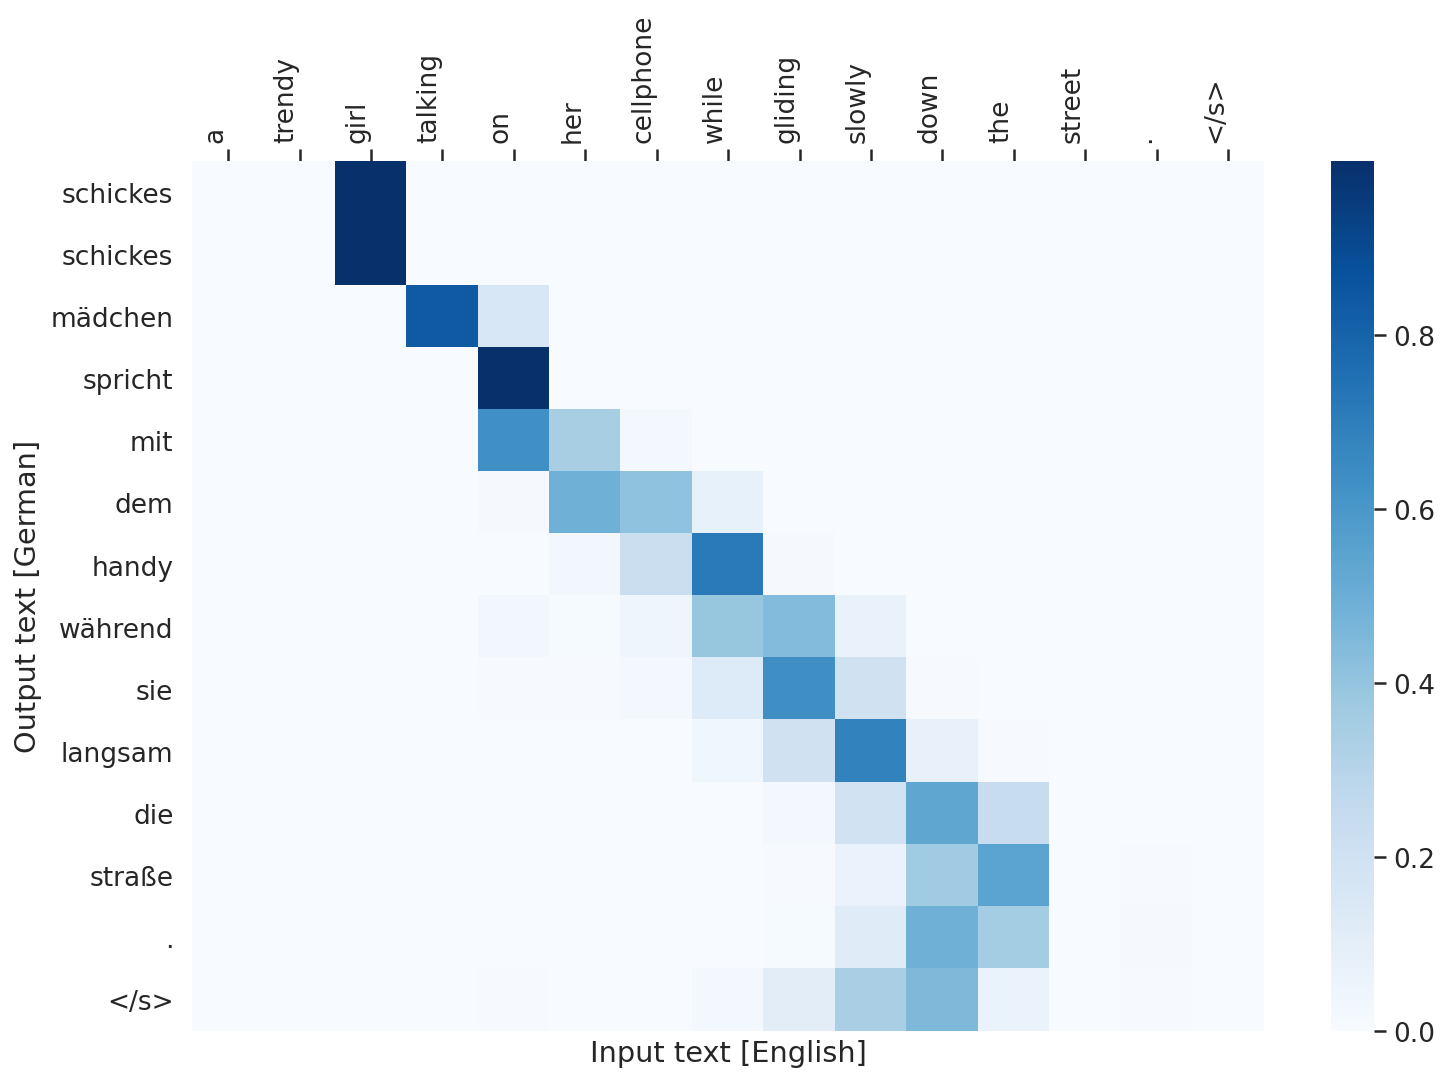

In [ ]:
example_idx = 7

source = vars(train_data.examples[example_idx])['src']
target = vars(train_data.examples[example_idx])['trg']

predicted, attention_scores = greedy_decode(model, source)

print(f'source: {source}\n')
print(f'target: {target}\n')
print(f'predicted: {predicted}\n')

plot_attention_scores(source, predicted, attention_scores)

source: ['construction', 'workers', 'standing', 'on', 'top', 'of', 'a', 'piece', 'of', 'machinery', '.']

target: ['bauarbeiter', 'stehen', 'auf', 'einer', 'maschine']

predicted: ['bauarbeiter', 'stehen', 'auf', 'einem', 'gerüst', '.', '</s>']



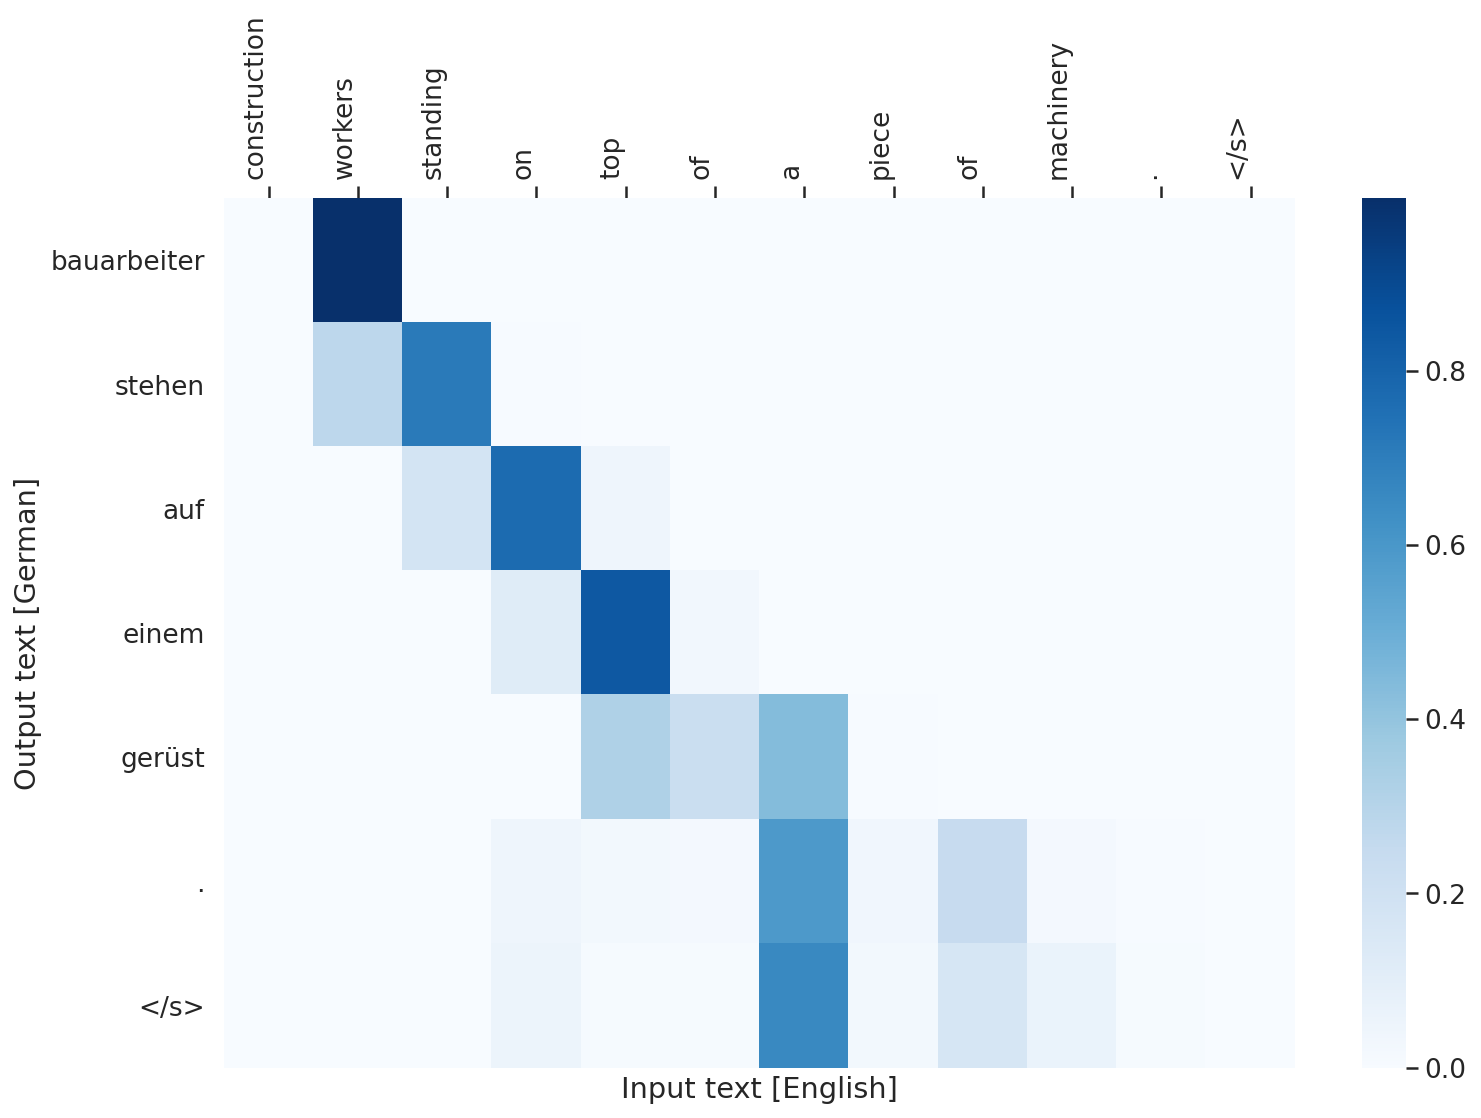

In [ ]:
example_idx = 24

source = vars(valid_data.examples[example_idx])['src']
target = vars(valid_data.examples[example_idx])['trg']

predicted, attention_scores = greedy_decode(model, source)

print(f'source: {source}\n')
print(f'target: {target}\n')
print(f'predicted: {predicted}\n')

plot_attention_scores(source, predicted, attention_scores)

source: ['people', 'walking', 'down', 'sidewalk', 'next', 'to', 'a', 'line', 'of', 'stores', '.']

target: ['leute', 'gehen', 'auf', 'einem', 'gehsteig', 'neben', 'einer', 'reihe', 'von', 'geschäften', '.']

predicted: ['personen', 'gehen', 'neben', 'einer', 'reihe', 'von', 'einer', 'treppe', 'entlang', '.', '</s>']



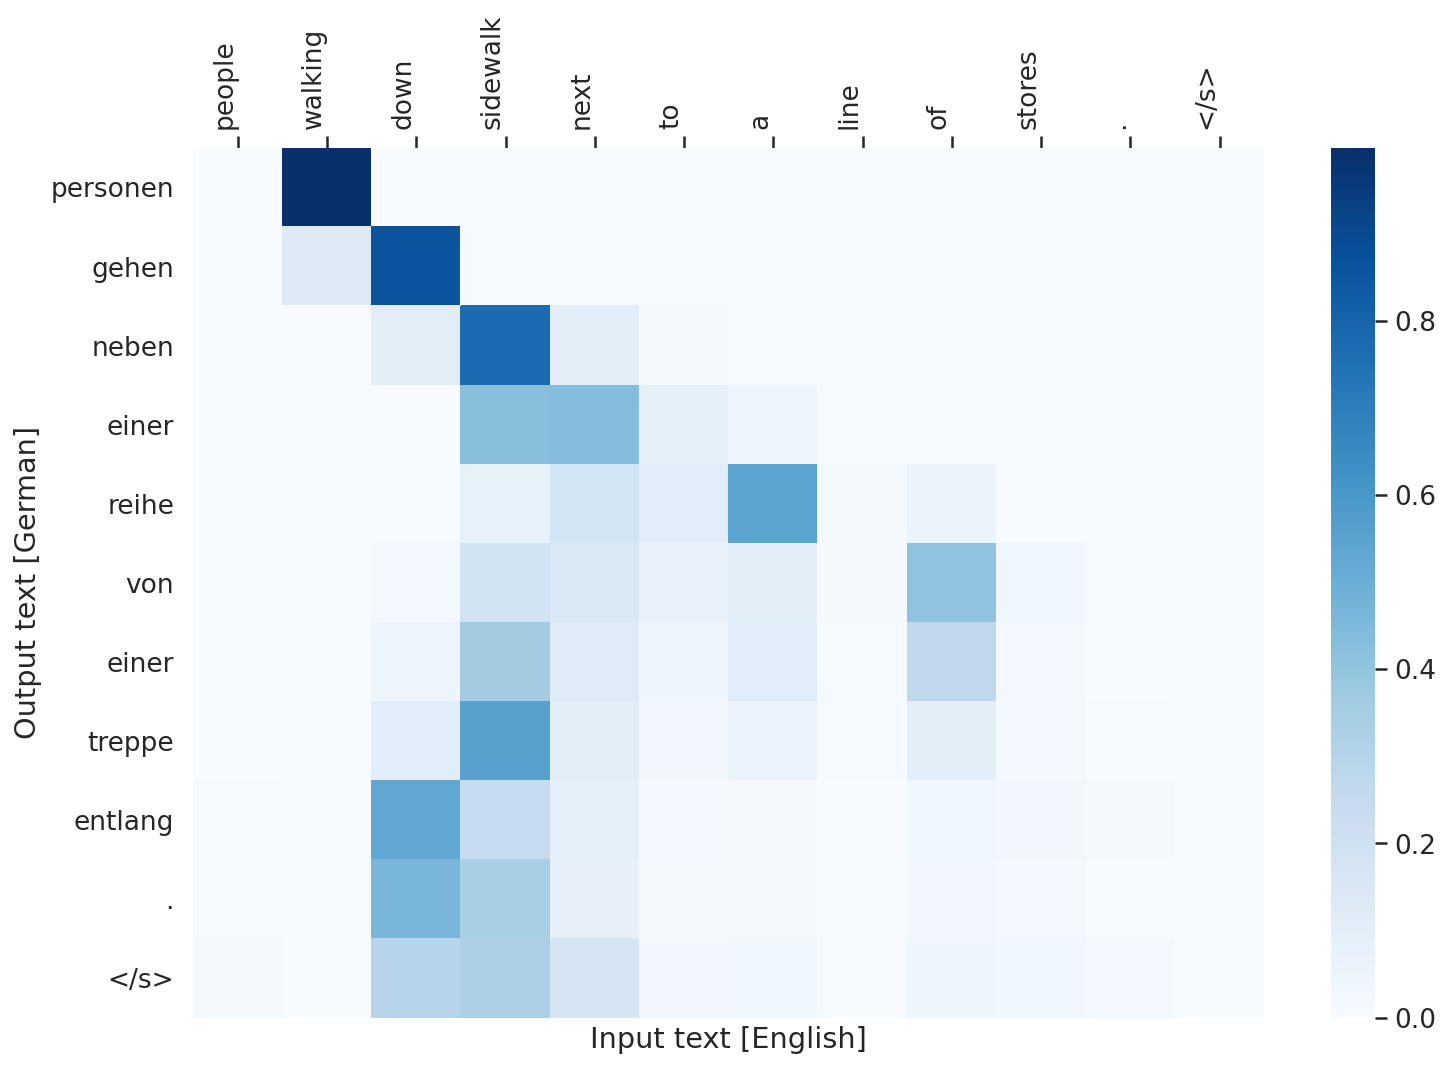

In [ ]:
example_idx = 50

source = vars(test_data.examples[example_idx])['src']
target = vars(test_data.examples[example_idx])['trg']

predicted, attention_scores = greedy_decode(model, source)

print(f'source: {source}\n')
print(f'target: {target}\n')
print(f'predicted: {predicted}\n')

plot_attention_scores(source, predicted, attention_scores)

## References

1. [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/pdf/1409.3215.pdf)
2. [Learning Phrase Representations using RNN Encoder–Decoder for Statistical Machine Translation](https://arxiv.org/pdf/1406.1078.pdf)
3. [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/pdf/1409.0473.pdf)
4. [Visualizing A Neural Machine Translation Model by Jay Alammar](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/)
5. [Sequence to Sequence (seq2seq) and Attention by Lena Voita](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)
6. [The Annotated Encoder Decoder](https://bastings.github.io/annotated_encoder_decoder/)
7. [PyTorch Seq2Seq by Ben Trevett](https://github.com/bentrevett/pytorch-seq2seq)
